# Stigma against Opioid Use Disorder varies by Personal Use status

```{margin} 
**To follow the full analysis, click through the hidden analysis code below**
```

In [4]:
# import packages
import os
import pandas as pd
import numpy as np
import pyreadstat
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)

In [5]:
# import data and metadata (data dictionaries)
os.chdir("P:/3652/Common/HEAL/Data-and-analytics/stigma-surveys/protocol-1/data-for-sharing/heal/")

# import data
df1 = pd.read_csv("jcoin_norc_omnibus_survey1_feb2020_072821-data.tsv", sep='\t')
df2 = pd.read_csv("jcoin_norc_omnibus_survey2_april2020_072821-data.tsv", sep='\t')
df3 = pd.read_csv("jcoin_norc_omnibus_survey3_june2020_072821-data.tsv", sep='\t')
df4 = pd.read_csv("jcoin_norc_omnibus_survey4_oct2020_072821-data.tsv", sep='\t')

# import metadata (data dictionaries)
meta1 = pd.read_csv("jcoin_norc_omnibus_survey1_feb2020_072821-data_dictionary.tsv", sep='\t')
meta2 = pd.read_csv("jcoin_norc_omnibus_survey2_april2020_072821-data_dictionary.tsv", sep='\t')
meta3 = pd.read_csv("jcoin_norc_omnibus_survey3_june2020_072821-data_dictionary.tsv", sep='\t')
meta4 = pd.read_csv("jcoin_norc_omnibus_survey4_oct2020_072821-data_dictionary.tsv", sep='\t')

In [6]:
# narrow down the dataset to only variables that are collected at each of the time-points

# standardize column names across datasets and metadatasets
for df in [df1, df2, df3, df4]:
    df.columns = df.columns.str.lower()
    
for meta in [meta1, meta2, meta3, meta4]:
    meta.name = meta.name.str.lower()  
    
# combine data from all surveys into one long dataset, keeping only vars available across all survey datasets (time-points)
all_df = pd.concat([df1, df2, df3, df4], keys=['feb2020','apr2020','jun2020','oct2020'], join="inner").reset_index().rename(columns={"level_0": "time-point"})

# combine metadata (data dictionaries) from all surveys into one long metadataset (data dictionary), keeping only vars available across all survey datasets
# stacking these and sorting by variable name allow the data user to compare the variable description acrosss time-points to ensure they are consistent, or alert the data-user to inconsistencies in variable description/definition across time-points 
all_meta = pd.concat([meta1, meta2, meta3, meta4], keys=['feb2020','apr2020','jun2020','oct2020'], join="inner").reset_index().rename(columns={"level_0": "time-point"})
all_meta = all_meta[all_meta['name'].isin(all_df.columns)].sort_values(by = ['name']) 

In [7]:
# narrow down the dataset to only a few interesting (and relatively clean, straightforward variables) - check for missingness and impute to fill in missing

# get subset of interesting variables
sub_df_1 = all_df[['time-point','weight','stigma_scale_score','age4','region4','personaluse_ever']]

# check for missing, impute missing stigma scale score vals with median per timepoint, impute missing personaluse_ever with mode, "No"

# check if missing values
sub_df_1.isnull().sum()

# get all var types
#sub_df_1.info()

# summary of numeric vars (weight and stigma_scale_score)
sub_df_1.describe()

# summary of cat vars (age4, region9, personaluse_ever)
sub_df_1.age4.value_counts(dropna=False)

# summary of cat vars (age4, region9, personaluse_ever)
sub_df_1.region4.value_counts(dropna=False)

# summary of cat vars (age4, region9, personaluse_ever)
sub_df_1.personaluse_ever.value_counts(dropna=False)

# impute missing stigma scale score values as the median score by survey time-point
sub_df_1['stigma_scale_score'].fillna(sub_df_1.groupby('time-point')['stigma_scale_score'].transform('median'),inplace=True)
sub_df_1.isnull().sum()

# replace missing values of personaluse_ever with mode value of 'No'
sub_df_1.personaluse_ever.fillna('No',inplace=True)
#sub_df_1.isnull().sum()

#sub_df_1

In [8]:
# define function to calculate weighted mean of across the full population for survey vars - necessary to properly weight in order to retain the validity of nationally representative survey sampling strategy 

# sum of weights will not be equal to count of individuals when we look at sub-groups of the full population; 
# will have to formally calculate weighted average
def weighted_mean(x, **kws):
    val, weight = map(np.asarray, zip(*x))
    weighted_mean = (val * weight).sum() / weight.sum()
    return (val * weight).sum() / weight.sum()

sub_df_1["score_and_weight"] = list(zip(sub_df_1.stigma_scale_score, sub_df_1.weight))

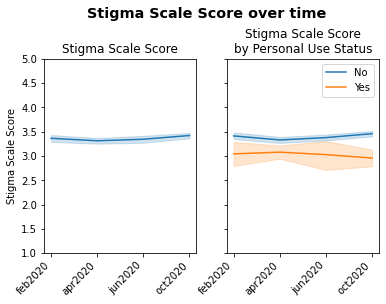

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Stigma Scale Score over time',fontsize='x-large',fontweight='bold')

one = sns.lineplot(ax = ax1,
             data = sub_df_1,
             x = 'time-point',
             y = 'score_and_weight',
             estimator = weighted_mean
             #hue = 'personaluse_ever'
            )

plt.draw()
one.set_xticks(one.get_xticks())
one.set_xticklabels(one.get_xticklabels(),rotation=45,horizontalalignment='right')
one.set_ylim(5, 1) # this is the average of 6 5-point likert scale questions; set the min/max accordingly
#for tick in one.get_xticklabels():
#    tick.set_rotation(45)
    
    
ax1.set_title('Stigma Scale Score')
ax1.set(ylabel='Stigma Scale Score')
ax1.set(xlabel='')
ax1.invert_yaxis()
#ax1.set_xticks(ax1.get_xticks())  # just get and reset whatever you already have
#one.set_xticklabels(one.get_xticklabels(),rotation=45,horizontalalignment='right')  # set the new/modified labels

two = sns.lineplot(ax = ax2,
             data = sub_df_1,
             x = 'time-point',
             y = 'score_and_weight',
             hue = 'personaluse_ever',
             estimator = weighted_mean
            )

plt.draw()
two.set_xticks(two.get_xticks())
two.set_xticklabels(two.get_xticklabels(),rotation=45,horizontalalignment='right')
two.set_ylim(5, 1) # this is the average of 6 5-point likert scale questions; set the min/max accordingly

ax2.set_title('Stigma Scale Score\nby Personal Use Status')
ax2.set(xlabel='')
ax2.invert_yaxis()

legend2 = ax2.legend()
#legend2.remove()

#leg = ax2.legend(loc='center', bbox_to_anchor=(1.1, -0.25), shadow=False, ncol=2, frameon=False)

plt.subplots_adjust(top=0.80)
plt.show()

```{margin} 
**To go to the data/study page on the HEAL Data Platform, follow this link:** my link
```

```{margin} 
**To go to an interactive analytic cloud workspace with the analysis code and data loaded, follow this link:** my link
```

**Problem**
<br>
Stigma against persons with opioid use disorder (OUD) likely leads to barriers to availability and uptake of treatment for OUD; Research on stigma against persons with OUD is sparse. 
<br><br>
Stigma is a known influencer of health in the case of substance use disorder and other health conditions (e.g. other mental health conditions, HIV/AIDS). However, research related specifically to stigma and OUD is sparse.
<br><br>
Stigma against persons with opioid use disorder (OUD) may act as a barrier to OUD treatment by lowering availability of treatment to and uptake of treatment by persons with OUD. It may turn politicians and philanthropists off from funding evidence-based treatment or individual doctors off from prescribing evidence-based treatment to their patients. It may breed ‘not in my backyard’ sentiments that prevent treatment centers from being located where they are most needed and degrade public support for public health approaches to OUD. And it may prevent persons with OUD from self-identifying and seeking the treatment they need.
<br><br>
We need to measure levels of stigma specifically against persons with OUD, as well as demographic and life-experience and attitudinal correlates of stigma in order to determine the scope of, and possible approach to addressing, impacts of stigma on OUD health outcomes.  

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Stigma Scale Score over time',fontsize='x-large',fontweight='bold')

one = sns.lineplot(ax = ax1,
             data = sub_df_1,
             x = 'time-point',
             y = 'score_and_weight',
             estimator = weighted_mean
             #hue = 'personaluse_ever'
            )

plt.draw()
one.set_xticks(one.get_xticks())
one.set_xticklabels(one.get_xticklabels(),rotation=45,horizontalalignment='right')
one.set_ylim(5, 1) # this is the average of 6 5-point likert scale questions; set the min/max accordingly
#for tick in one.get_xticklabels():
#    tick.set_rotation(45)
    
    
ax1.set_title('Stigma Scale Score')
ax1.set(ylabel='Stigma Scale Score')
ax1.set(xlabel='')
ax1.invert_yaxis()
#ax1.set_xticks(ax1.get_xticks())  # just get and reset whatever you already have
#one.set_xticklabels(one.get_xticklabels(),rotation=45,horizontalalignment='right')  # set the new/modified labels

two = sns.lineplot(ax = ax2,
             data = sub_df_1,
             x = 'time-point',
             y = 'score_and_weight',
             hue = 'personaluse_ever',
             estimator = weighted_mean
            )

plt.draw()
two.set_xticks(two.get_xticks())
two.set_xticklabels(two.get_xticklabels(),rotation=45,horizontalalignment='right')
two.set_ylim(5, 1) # this is the average of 6 5-point likert scale questions; set the min/max accordingly

ax2.set_title('Stigma Scale Score\nby Personal Use Status')
ax2.set(xlabel='')
ax2.invert_yaxis()

legend2 = ax2.legend()
#legend2.remove()

#leg = ax2.legend(loc='center', bbox_to_anchor=(1.1, -0.25), shadow=False, ncol=2, frameon=False)

plt.subplots_adjust(top=0.80)
plt.show()

**Data** 
<br>
From a study by Taylor et al., a repeated cross-sectional survey of a nationally representative sample of approximately 1000 persons, repeated every few months over the course of several years starting in Feb 2020. Survey questions ask about respondent demographics, personal and familial experience of illicit opioid use, personal and familial experience of contact with the criminal justice system, as well as personal attitudes towards OUD, persons with OUD, and policies related to OUD. 
<br><br>
Stigma towards persons with OUD is measured as the average of the respondent’s answers to 6 questions. Each question is measured on a 5-point Likert scale (strongly agree to strongly disagree); the first four items are reverse-coded, so that higher scores indicate higher stigma. A score of 3 on any of these questions corresponds to an answer of ‘Do not agree or disagree’.
<br><br>
Items include:
1. I would be willing to have a person with a past history of opioid use disorder/addiction start working closely with me on a job. 
2. I am comfortable having a person with a past history of opioid use disorder/addiction marry into my family.
3. I would be willing to have a person with a current opioid use disorder/addiction start working closely with me on a job. 
4. I would be comfortable to have a person with a current opioid use disorder/addiction marry into my family.
5. People with a current addiction to opioids/prescription pain medications are more dangerous than the general population.
6. A person who is currently addicted to opioids/prescription pain medication cannot be trusted.

<br>

**Take-away** 
<br>
Overall, stigma towards persons with OUD is lower than expected, with average stigma levels just above a value of 3 (a stigma level considered to be ‘moderate’). Stigma towards persons with OUD is lower among persons who report personal experience with illicit opioid use. 
<br><br>

In [ ]:
# https://stackoverflow.com/questions/25654845/how-can-i-create-a-text-box-for-a-note-in-markdown

<div class="warning" style='padding:0.1em; background-color:#E9D8FD; color:#69337A'>
<span>
<p style='margin-top:1em; text-align:center'>
<b>Citation</b></p>
<p style='margin-left:1em;'>
<b>Data Citation</b> 
<br>
Harold Pollack, Johnathon Schneider, Bruce Taylor. JCOIN 026: Brief Stigma Survey. Chicago, IL: Center for Translational Data Science HEAL Data Platform (distributor) via Center for Translational Data Science JCOIN Data Commons (repository & distributor), 2022-04-08. (HEAL Data Platform branded doi goes here)
<br><br>
<b>Brief Article Citation</b> 
<br>
What format should this be? 
</p>
</span>
</div>


    

